In [1]:
import pandas as pd
from nltk import word_tokenize 
import json
import numpy as np
from keras.utils import to_categorical
from random import choice
from tqdm import tqdm
from keras_bert import load_trained_model_from_checkpoint, Tokenizer
from keras.layers import Dense, Activation, Multiply, Add, Lambda
import re, os
import codecs
import jieba.posseg as pseg
import jieba
import keras
import keras.backend as K
from keras.callbacks import *
import os
from keras.layers import *
from keras.models import Model
import keras.backend as K
from keras.callbacks import Callback
from keras.optimizers import Adam

In [2]:
df=pd.read_csv("tweet_dataset.csv")
train= pd.DataFrame()
train['text']= df['text']
train['Sentiment']=df['new_sentiment']
train=train.dropna()

In [5]:
#preprocessing to clean up the text
import re
def process(tweet):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)
    return tweet.lower()

In [6]:
#preprocessing and validation set
train["text"]=train["text"].apply(lambda x:process(x))
df=train.sample(frac=1)

df_val=df[-2000:]  #validation set
df=df[:-2000]

In [9]:
#tokenization and turn class into numbers
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
mode = 0
maxlen =128 
learning_rate = 2e-5
min_learning_rate = 1e-5
config_path = './cased_L-12_H-768_A-12/bert_config.json'
checkpoint_path = './cased_L-12_H-768_A-12/bert_model.ckpt'
dict_path = './cased_L-12_H-768_A-12/vocab.txt'


token_dict = {}

with codecs.open(dict_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

class OurTokenizer(Tokenizer):
    def _tokenize(self, text):
        R = []
        for c in word_tokenize(text):
            if c in self._token_dict:
                R.append(c)
            else:
                R.append('[UNK]') # rests are '[UNK]'
        return R

tokenizer = OurTokenizer(token_dict,cased=True)

d_category_to_number=dict(zip(df["Sentiment"].unique(),list(range(len(df["Sentiment"].unique())))))   
df["Sentiment"]=df["Sentiment"].map(d_category_to_number)
df_val["Sentiment"]=df_val["Sentiment"].map(d_category_to_number)
num_classes = len(df["Sentiment"].unique())

Using TensorFlow backend.
/Users/yaozhao/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/yaozhao/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/yaozhao/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/yaozhao/opt/anaconda3/lib/pytho

In [10]:
#padding with 0 to make the texts the same length
def seq_padding(X, padding=0):
    L = [len(x) for x in X]
    ML = max(L)
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])


#prepare data for traning
df=df.sample(frac=1)
label=list(df["Sentiment"])
DATA_LIST = []
for t,l in zip(df["text"],label):
    DATA_LIST.append((t, to_categorical(l, num_classes )))
DATA_LIST_val=[]
for t,l in zip(df_val["text"],list(df_val["Sentiment"])):
    DATA_LIST_val.append((t, to_categorical(l, num_classes )))

In [11]:
#create data generator to feed data into model
class data_generator:
    def __init__(self, data, batch_size=32, shuffle=True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.steps = len(self.data) // self.batch_size
        if len(self.data) % self.batch_size != 0:
            self.steps += 1
 
    def __len__(self):
        return self.steps
 
    def __iter__(self):
        
        while True:
            idxs = list(range(len(self.data)))
            
            if self.shuffle:
                np.random.shuffle(idxs)
 
            X1, X2, Y = [], [], []
            for i in idxs:
                d = self.data[i]
                text = d[0][:maxlen]
                x1, x2 = tokenizer.encode(first=text)
                y = d[1]
                X1.append(x1)
                X2.append(x2)
                Y.append([y])
                if len(X1) == self.batch_size or i == idxs[-1]:
                    X1 = seq_padding(X1)
                    X2 = seq_padding(X2)
                    Y = seq_padding(Y)
                    
                    yield [X1, X2], Y[:, 0, :]
                    [X1, X2, Y] = [], [], []

                    
#load pre-train bert model and feed data into model                  
def build_bert(nclass):
    bert_model = load_trained_model_from_checkpoint(config_path, checkpoint_path, seq_len=None)  #load pre-train model
 
    for l in bert_model.layers:
        l.trainable = True
 
    x1_in = Input(shape=(None,))
    x2_in = Input(shape=(None,))
 
    x = bert_model([x1_in, x2_in])
    x = Lambda(lambda x: x[:, 0])(x) # take the corresponding [CLS] vactor to do classification
    p = Dense(num_classes, activation='softmax')(x)
 
    model = Model([x1_in, x2_in], p)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(2e-5),    #small learning rate
                  metrics=['accuracy'])
    print(model.summary())
    return model

model = build_bert(num_classes)
early_stopping = EarlyStopping(monitor='val_acc', patience=10)   #early stop to prevent overfitting
plateau = ReduceLROnPlateau(monitor="val_acc", verbose=1, mode='max', factor=0.5, patience=2) #reduce the learning rate when the accuracy don't increase
checkpoint = ModelCheckpoint('bestmodel2.hdf5', monitor='val_acc',verbose=2, save_best_only=True, mode='max', save_weights_only=True) #save the best model

train_D = data_generator(DATA_LIST, shuffle=True)
valid_D = data_generator(DATA_LIST_val, shuffle=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, None, 768)    107719680   input_1[0][0]                    
                                                                 input_2[0][0]                    
_____________________

In [52]:
#Model training
if not os.path.exists("bestmodel2.hdf5"):
    history=model.fit_generator(
        train_D.__iter__(),
        steps_per_epoch=len(DATA_LIST)//32,
        epochs=5,
        validation_data=valid_D.__iter__(),
        validation_steps=len(valid_D),
        callbacks=[early_stopping, plateau, checkpoint],
    )
    import matplotlib.pyplot as plt
    val_loss = history.history['val_loss']
    loss = history.history['loss']
    epochs = range(1, len(loss ) + 1)
    plt.title('Loss')
    plt.plot(epochs, loss, 'red', label='Training loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss')
    plt.legend()
    plt.show()

    plt.cla()
    val_loss = history.history['val_acc']
    loss = history.history['acc']
    epochs = range(1, len(loss ) + 1)

    plt.title('accuracy')
    plt.plot(epochs, loss, 'red', label='Training accuracy')
    plt.plot(epochs, val_loss, 'blue', label='Validation accuracy')
    plt.legend()
    plt.show()
else:
    print ("Load trained model.")

Load trained model.


In [14]:
#load the best model
model.load_weights("bestmodel2.hdf5")

In [57]:
#evaluation
def model_evaluation(DATA_LIST_val):
    ypre=[]
    ytrue=[]
    yauc=[]
    
    for i in range(len(DATA_LIST_val)):
        x1, x2 = tokenizer.encode(first=DATA_LIST_val[i][0][:maxlen])
        tmp_pre=list(np.argmax(model.predict([[x1],[x2]]),axis=1))
        tmp_ytrue=[np.argmax(DATA_LIST_val[i][1],axis=0)]
        ypre+=tmp_pre
        ytrue+=tmp_ytrue
        
    from sklearn import metrics
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score
    
    def val_confusion_matrix(valp,valy):
        sns.set()
        np.set_printoptions(suppress=True)
        f,ax=plt.subplots()
        valp=np.array(valp)
        valy=np.array(valy)
        C2= confusion_matrix(valy , valp, labels=list(range(3)))
        print(C2)
        sns.heatmap(C2,annot=True,ax=ax,cmap="YlGnBu",fmt='.20g') #heatmap for confusion matrix
        ax.set_title('confusion matrix')
        ax.set_xlabel('predict')
        ax.set_ylabel('true')
        plt.show()
    def val_evaluation_metric(val_data,val_y):
        val_confusion_matrix(val_data,val_y)
    
    val_evaluation_metric(ypre,ytrue)
    print (accuracy_score(ytrue,ypre))
    print(classification_report( ytrue,ypre,digits=4,target_names=[str(i) for i in list(range(3))]))

[[535   7  86]
 [ 12 428 112]
 [ 80  94 646]]


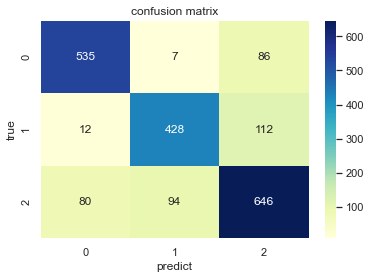

0.8045
              precision    recall  f1-score   support

           0     0.8533    0.8519    0.8526       628
           1     0.8091    0.7754    0.7919       552
           2     0.7654    0.7878    0.7764       820

    accuracy                         0.8045      2000
   macro avg     0.8092    0.8050    0.8070      2000
weighted avg     0.8050    0.8045    0.8046      2000



In [58]:
#print out evaluation results
model_evaluation(DATA_LIST_val)

# Sentiment Prediction

In [19]:
df_vax = pd.read_csv('vaccination_all_tweets.csv')

In [20]:
df_vax["text"]=df_vax["text"].apply(lambda x:process(x))

In [21]:
df_vax["text"]=df_vax["text"].fillna("")

In [22]:
d_number_to_cate=dict(zip(d_category_to_number.values(),d_category_to_number.keys()))
def getlabels(texts):
    X1=[]
    X2=[]
    for text in texts:
        text = text[:maxlen]
        x1, x2 = tokenizer.encode(first=text)
        
        X1.append(x1)
        X2.append(x2)
    X1 = seq_padding(X1)
    X2 = seq_padding(X2)
    return  [d_number_to_cate[i] for i in list(np.argmax(model.predict([X1, X2]),axis=-1))]

In [23]:
from tqdm  import tqdm
prelabel=[]
for i in tqdm(range(0,df_vax.shape[0],64)):
    tmppre=getlabels(df_vax["text"][i:i+64])
    prelabel+=tmppre

100%|██████████| 2120/2120 [2:20:57<00:00,  3.99s/it]  


In [24]:
df_vax['Sentiment'] = prelabel

In [25]:
vax=df_vax

<AxesSubplot:>

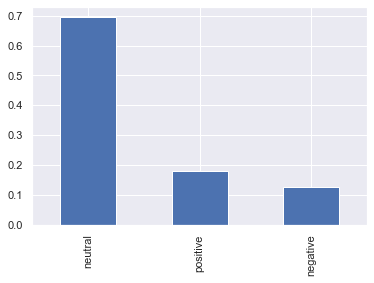

In [26]:
df_vax['Sentiment'].value_counts(normalize=True).plot.bar()

In [27]:
vax['date'] = pd.to_datetime(vax['date'], errors='coerce').dt.date
vax['Sentiment'] = vax['Sentiment'].map({'negative':-1,'neutral':0,'positive':1})
vax.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,Sentiment
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20,same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,0
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13,while the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,0
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12,#coronavirus #sputnikv #astrazeneca #pfizerbio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,0
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12,"facts are immutable, senator, even when youre ...",NaN,Twitter Web App,446,2129,False,0
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12,explain to me again why we need a vaccine #whe...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,0


In [28]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

vax_sentiment = pd.DataFrame()
vax_sentiment['Vaccine']=all_vax

In [29]:
sentiments=list()

# Variance with Time

In [30]:
# !pip install -U seaborn

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

def time_variance(vacc) :
    if vacc=='all':
        vacc=vax
    else :   
        vacc=vax[vax['text'].str.lower().str.contains(vacc)]
        sentiments.append(vacc.Sentiment.mean())

    temp=pd.DataFrame()
    temp['date'] = sorted(vacc['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(vacc[vacc['date']==date].Sentiment.mean())

    temp['Sentiment']=senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title("Variance of Sentiment wrt Time",size=24)
    axs.grid()

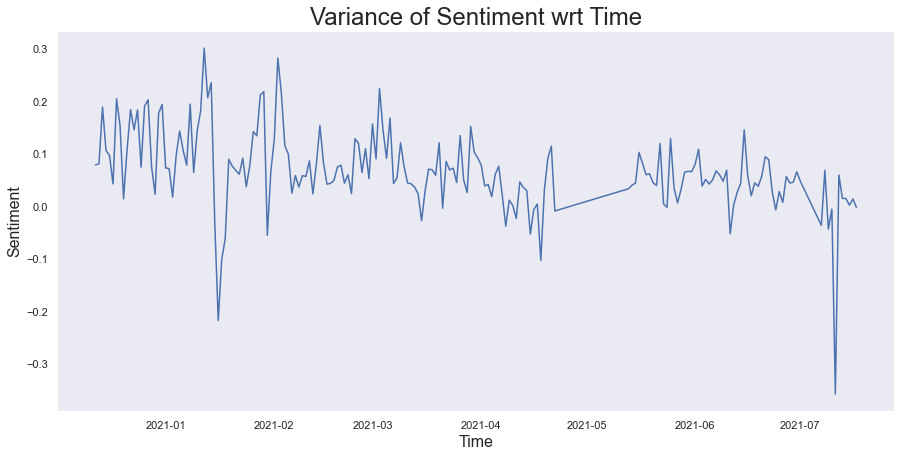

In [32]:
time_variance('all')

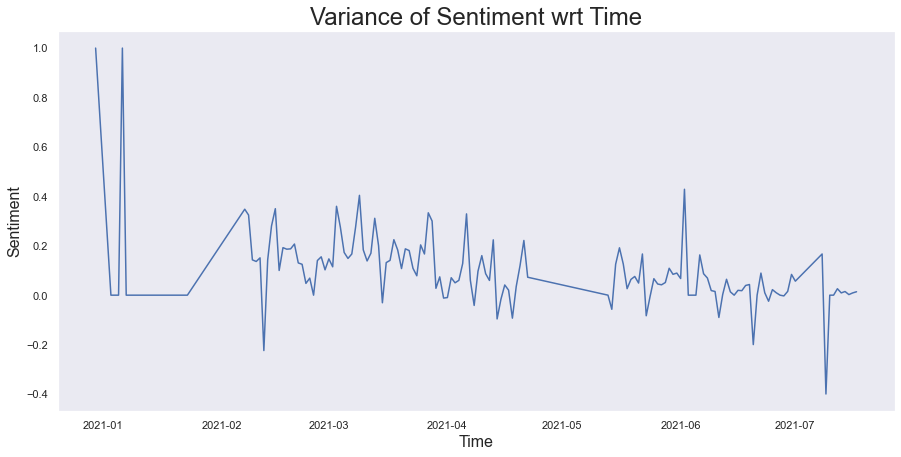

In [33]:
time_variance('covaxin')

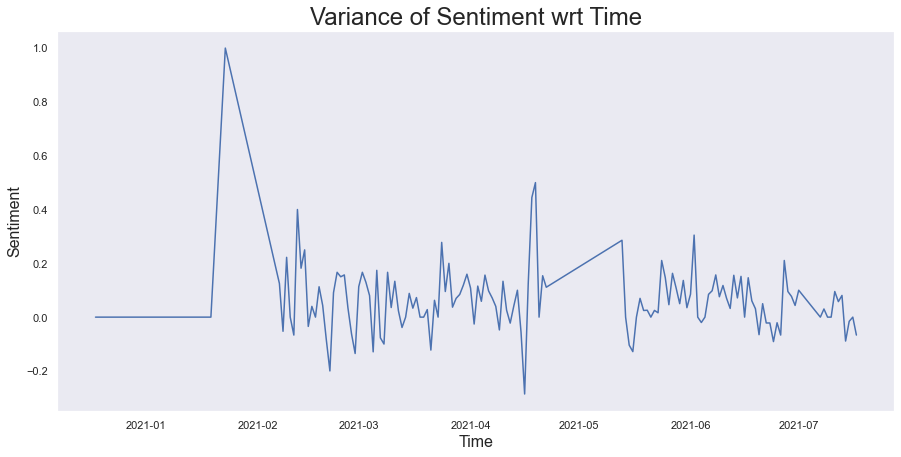

In [34]:
time_variance('sinopharm')

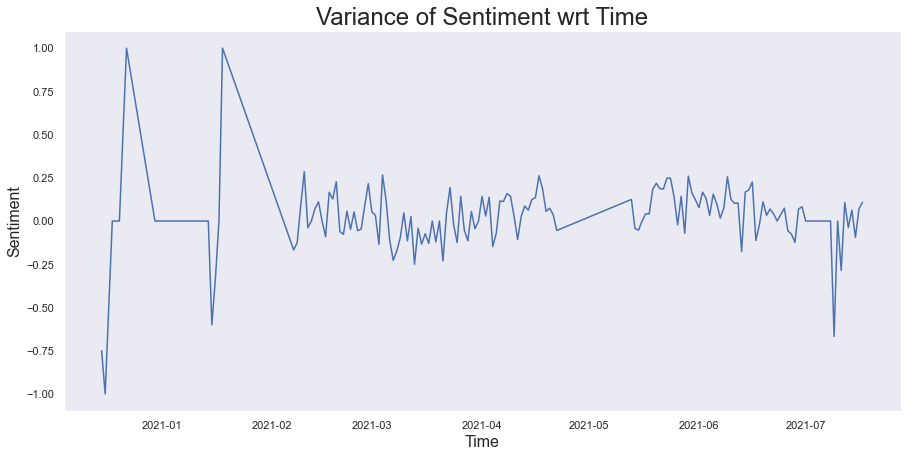

In [35]:
time_variance('sinovac')

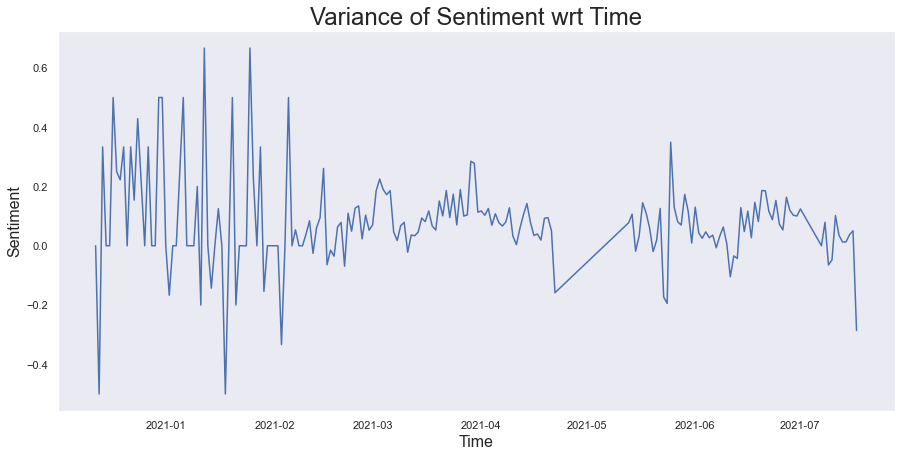

In [36]:
time_variance('moderna')

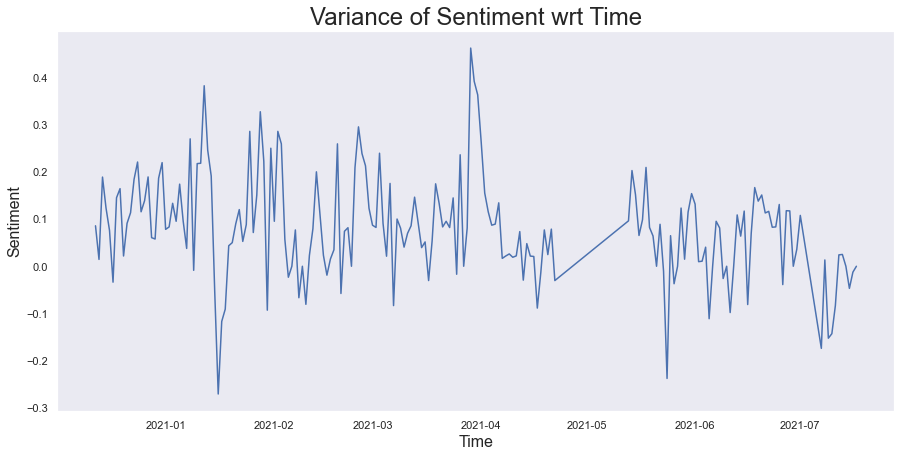

In [37]:
time_variance('pfizer')

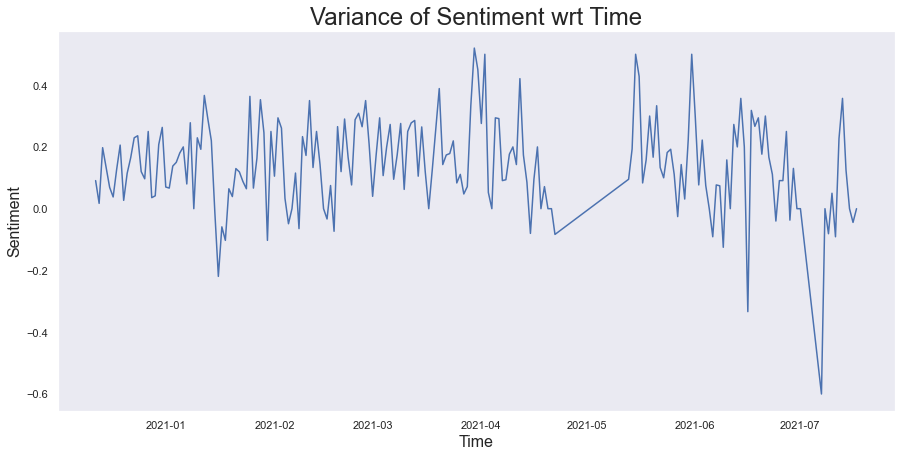

In [38]:
time_variance('biontech')

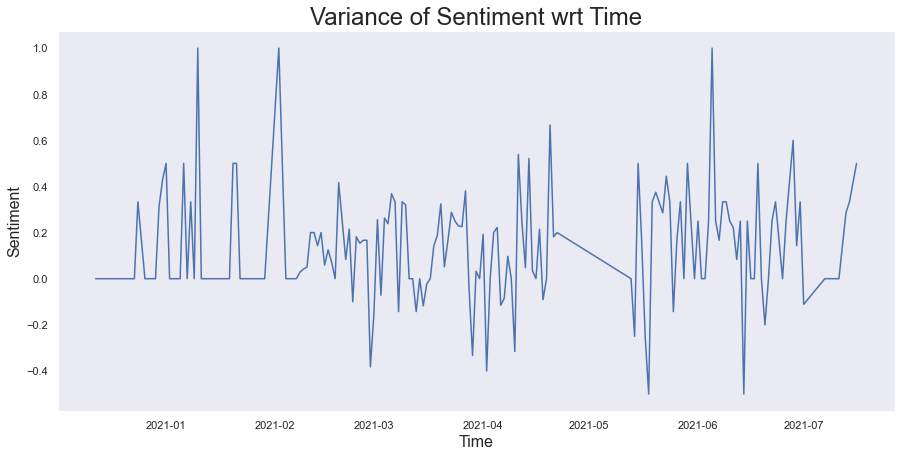

In [39]:
time_variance('oxford')

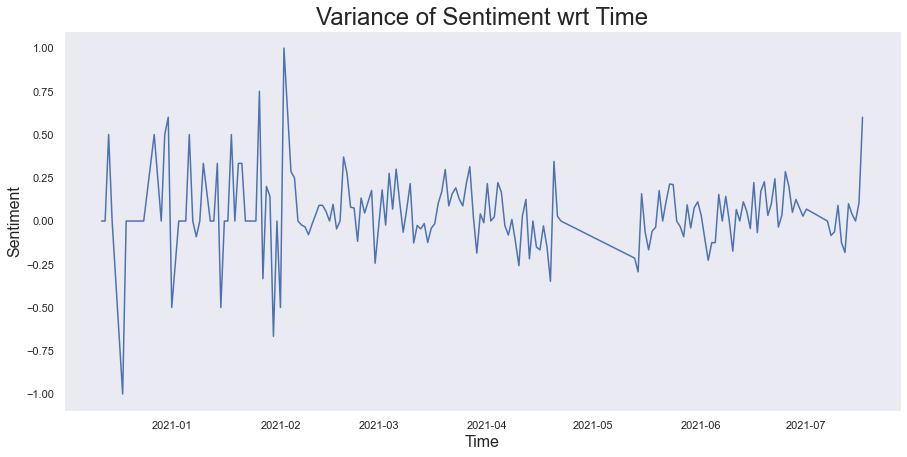

In [40]:
time_variance('astrazeneca')

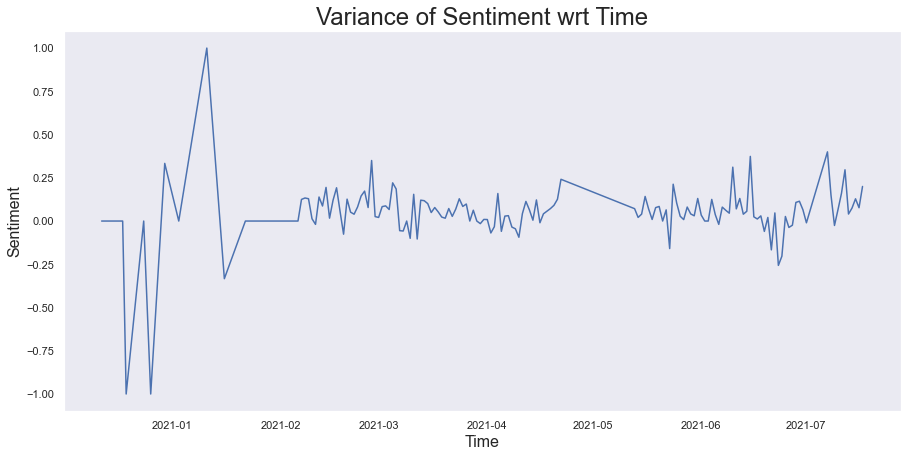

In [41]:
time_variance('sputnik')

Text(0.5, 1.0, 'Mean Sentiment of Vaccines')

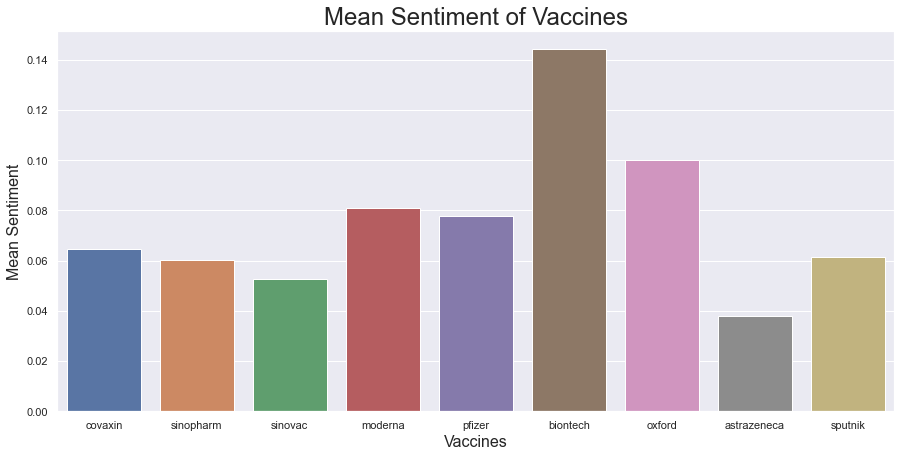

In [42]:
vax_sentiment['Sentiment']=sentiments

fg,axs=plt.subplots(figsize=(15,7))
sns.barplot(ax=axs,x='Vaccine',y='Sentiment',data=vax_sentiment)
axs.set_xlabel("Vaccines",size=16)
axs.set_ylabel("Mean Sentiment",size=16)
axs.set_title("Mean Sentiment of Vaccines",size=24)

# Comparison among countries

In [43]:
vax=vax.dropna(subset=["user_location"])

In [44]:

country_sentiment=pd.DataFrame()
countries=['india','usa','canada','germany','spain','pakistan','uk','brazil','russia','italy','australia','france','argentina','uae','israel','mexico','japan']
country_sentiment['countries']=countries
senti=list()

for country in countries :
    senti.append(vax[vax['user_location'].str.lower().str.contains(country)].Sentiment.mean())
    
country_sentiment['Sentiment']=senti


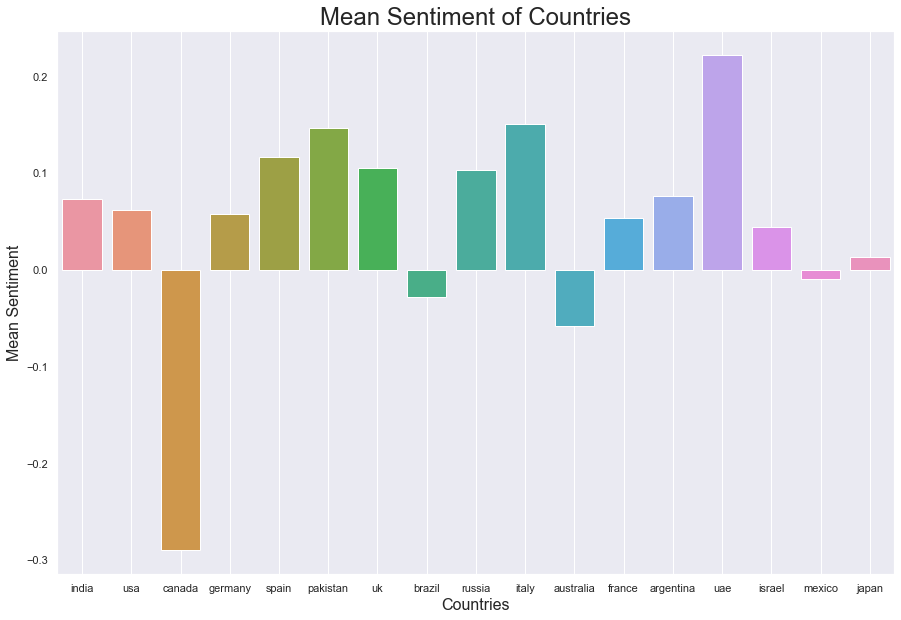

In [45]:
fg,axs=plt.subplots(figsize=(15,10))
sns.barplot(ax=axs,x='countries',y='Sentiment',data=country_sentiment)
axs.set_xlabel("Countries",size=16)
axs.set_ylabel("Mean Sentiment",size=16)
axs.set_title("Mean Sentiment of Countries",size=24)
axs.grid()

# Varinace with Time in Different Countrie

In [46]:
def time_variance_country(country) :
    count=vax[vax['user_location'].str.lower().str.contains(country)]

    temp=pd.DataFrame()
    temp['date'] = sorted(count['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(count[count['date']==date].Sentiment.mean())

    temp['Sentiment']=senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title("Variance of Sentiment wrt Time",size=24)
    axs.grid()

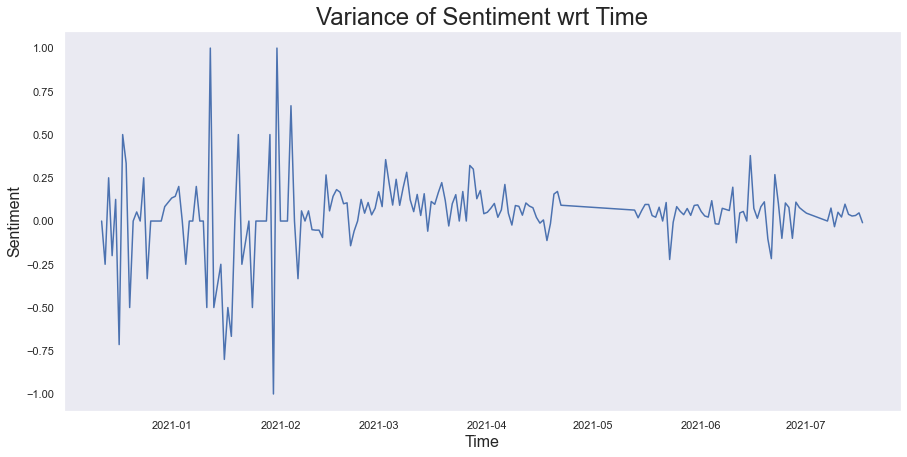

In [47]:
time_variance_country('india')

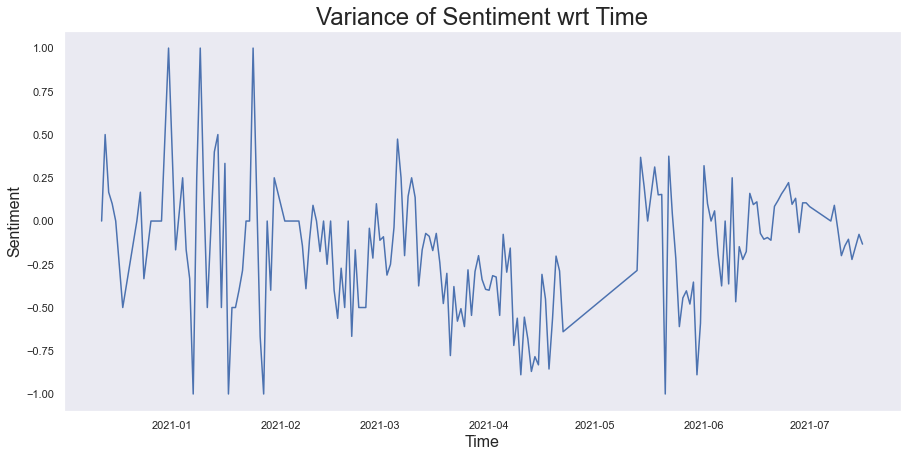

In [48]:

time_variance_country('canada')

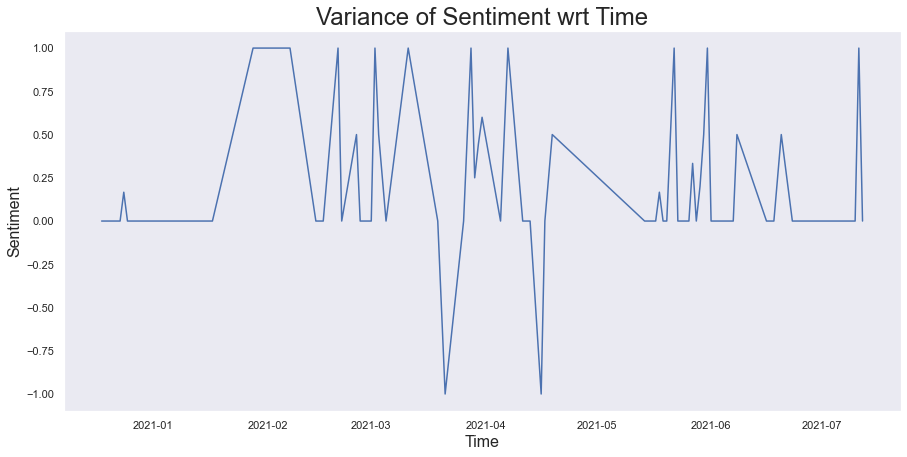

In [49]:
time_variance_country('uae')

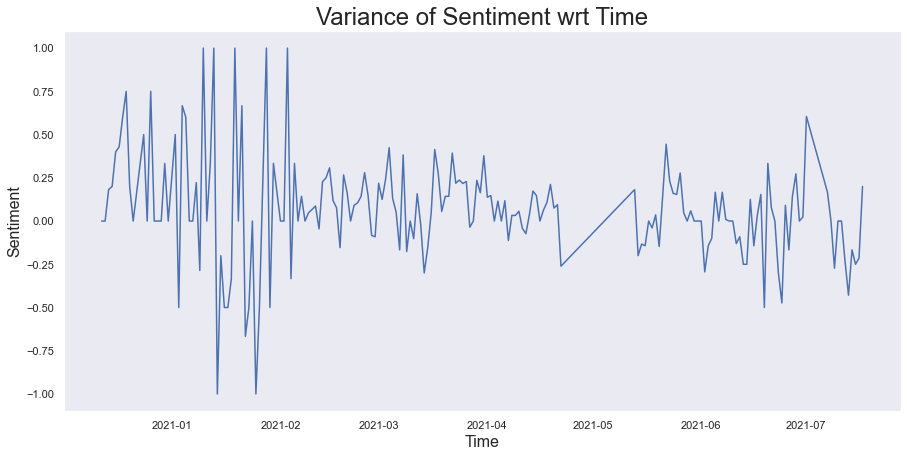

In [50]:

time_variance_country('usa')

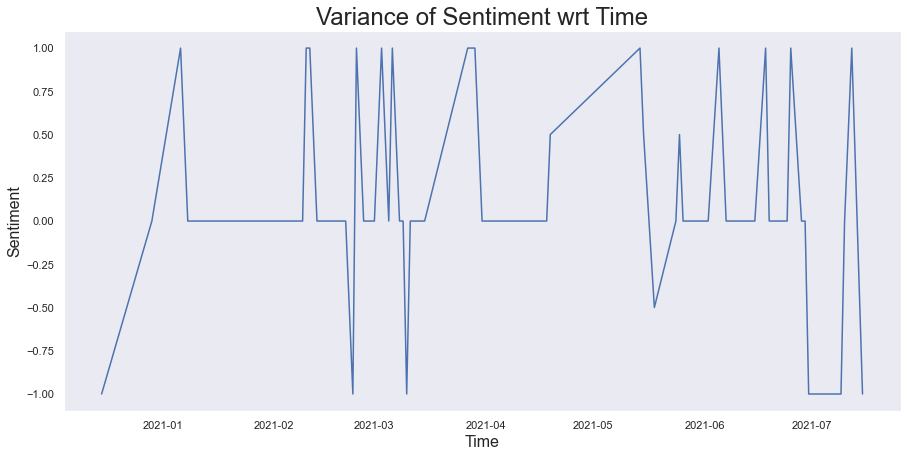

In [51]:
time_variance_country('spain')